# **Project work: A mini segmentation challenge**

<div style="color:#777777;margin-top: -15px;">
<b>Course</b>: MSLS / CO4 |
<b>Version</b>: v1.2 <br><br>
<!-- Date: 10.04.2025 -->
<!-- Comments: Fully refactored. -->
</div>


**Student**: $\Rightarrow$  Alexander Moor, Curdin Bosshart
**Email**: $\Rightarrow$ alexander.moor@students.fhnw.ch, curdin.bosshart@students.fhnw.ch
**University**: $\Rightarrow$  FHNW
**Semester**: $\Rightarrow$  2. Semester
**Date**: $\Rightarrow$  DATE OF SUBMISSION


<br>

## **Abstract**

*$\Rightarrow$ A brief summary of your project in 2-3 sentences.*



<br><br>

----

## **Table of contents**
<!-- Unfortunately, the following does not always work correctly -->
* [1. Dataset](#sec_dataset)  
* [2. Preprocessing](#sec_preprocessing)  
* [3. Manual segmentation](#sec_manual_segmentation)  
* [4. Automated segmentation](#sec_automated_segmentation)  
* [5. Evaluation](#sec_evaluation)  
* [6. Discussion](#sec_discussion)  
* [Appendix: Hints](#sec_hints)  


---

## **Prerequisites / Setup**

$\Rightarrow$ Special setup instructions, imports and configurations go here.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import nibabel as nib
import pydicom
import PIL

# Jupyter / IPython configuration:
# Automatically reload modules when modified
%load_ext autoreload
%autoreload 2

# Enable vectorized output (for nicer plots)
%config InlineBackend.figure_formats = ["svg"]

# Inline backend configuration
%matplotlib inline

# Enable this line if you want to use the interactive widgets
# It requires the ipympl package to be installed.
#%matplotlib widget

import sys
sys.path.insert(0, "../")
import tools

---


<a id='sec_dataset'></a>

## **Dataset**

*$\Rightarrow$ Describe your dataset.*

### **Requirements**
* Provide a dataset with at least 10 image samples.
* The dataset must be no larger than 200 MB. If it exceeds this size, please contact the tutor in advance.
* Ensure that you have the rights to use and share the data (check the usage license).
* The images should clearly show a recognizable structure of interest.
* Avoid datasets with too much variation.
* Each student/team must use a different dataset!



---

<a id='sec_preprocessing'></a>

## **Preprocessing**

*$\Rightarrow$ Describe the pre-processing steps applied to enhance the input images.*

*Note: The specific steps will depend on your dataset and the intended application.*

### **Instructions:**
* Improve image quality by reducing noise, adjusting contrast, or normalizing intensity.
* Standardize image dimensions and formats for consistent input to analysis pipelines.
* Highlight or isolate relevant structures to support downstream processing.




---

<a id='sec_manual_segmentation'></a>

## **Manual segmentation**

*$\Rightarrow$ Describe the manual segmentation step*


### **Instructions:**
* Use a suitable tool to manually segment the structures of interest.  
* These segmentations will be needed for further analysis (or model training).  
* If your dataset already includes segmentation masks, you still need to demonstrate how such masks can be created manually.

---

<a id='sec_automated_segmentation'></a>

## **Automated Segmentation**

*$\Rightarrow$ Describe how the images are segmented using Python.*

### **Instructions:**
* Perform the segmentation in Python.
* You may use external libraries or tools (e.g., OpenCV, scikit-image).
* Implement a function `segment(image, ...)` that takes an image as input and returns a segmentation mask for the structure of interest.


In [ ]:
import json

coco_files = [
    'images/downloaded_from_source/train/_annotations.coco.json',
    'images/downloaded_from_source/valid/_annotations.coco.json',
    'images/downloaded_from_source/test/_annotations.coco.json'
]

for coco_path in coco_files:
    print(f"\nInspecting {coco_path}...")
    with open(coco_path, 'r') as f:
        data = json.load(f)

    print(f"- Number of images: {len(data.get('images', []))}")
    print(f"- Number of annotations: {len(data.get('annotations', []))}")
    print(f"- Number of categories: {len(data.get('categories', []))}")

    print("- Categories:")
    for cat in data.get('categories', []):
        print(f"    ID: {cat['id']}, Name: {cat['name']}")
    
    # Check sample image
    if data.get('images'):
        sample_img = data['images'][0]
        print(f"- Example image entry: {sample_img}")
    
    # Check sample annotation
    if data.get('annotations'):
        sample_ann = data['annotations'][0]
        print(f"- Example annotation entry: {sample_ann}")


In [ ]:
import json
import os

coco_files = [
    'images/downloaded_from_source/train/_annotations.coco.json',
    'images/downloaded_from_source/valid/_annotations.coco.json',
    'images/downloaded_from_source/test/_annotations.coco.json'
]

merged = {
    'info': {},
    'licenses': [],
    'images': [],
    'annotations': [],
    'categories': []
}

image_id_offset = 0
annotation_id_offset = 0
categories_set = False

for coco_path in coco_files:
    with open(coco_path, 'r') as f:
        data = json.load(f)

    if not categories_set:
        merged['categories'] = data['categories']
        categories_set = True

    # Adjust image IDs
    for img in data['images']:
        original_id = img['id']
        img['id'] = original_id + image_id_offset
        merged['images'].append(img)

    # Adjust annotation IDs + remap image_id links
    for ann in data['annotations']:
        ann['id'] += annotation_id_offset
        ann['image_id'] += image_id_offset
        merged['annotations'].append(ann)

    image_id_offset = max(img['id'] for img in merged['images']) + 1
    annotation_id_offset = max(ann['id'] for ann in merged['annotations']) + 1

# Save merged file
with open('images/unified_image_pool/all_annotations.coco.json', 'w') as f:
    json.dump(merged, f)

print(f"Saved merged COCO file with {len(merged['images'])} images and {len(merged['annotations'])} annotations.")


In [ ]:
import os
import shutil

# Define folders
folders = [
    'images/downloaded_from_source/train',
    'images/downloaded_from_source/valid',
    'images/downloaded_from_source/test'
]

dest_folder = 'images/unified_image_pool/'
os.makedirs(dest_folder, exist_ok=True)

for folder in folders:
    for file in os.listdir(folder):
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            src = os.path.join(folder, file)
            dst = os.path.join(dest_folder, file)
            if not os.path.exists(dst):
                shutil.copy2(src, dst)

print(f"Copied all images into {dest_folder}/")


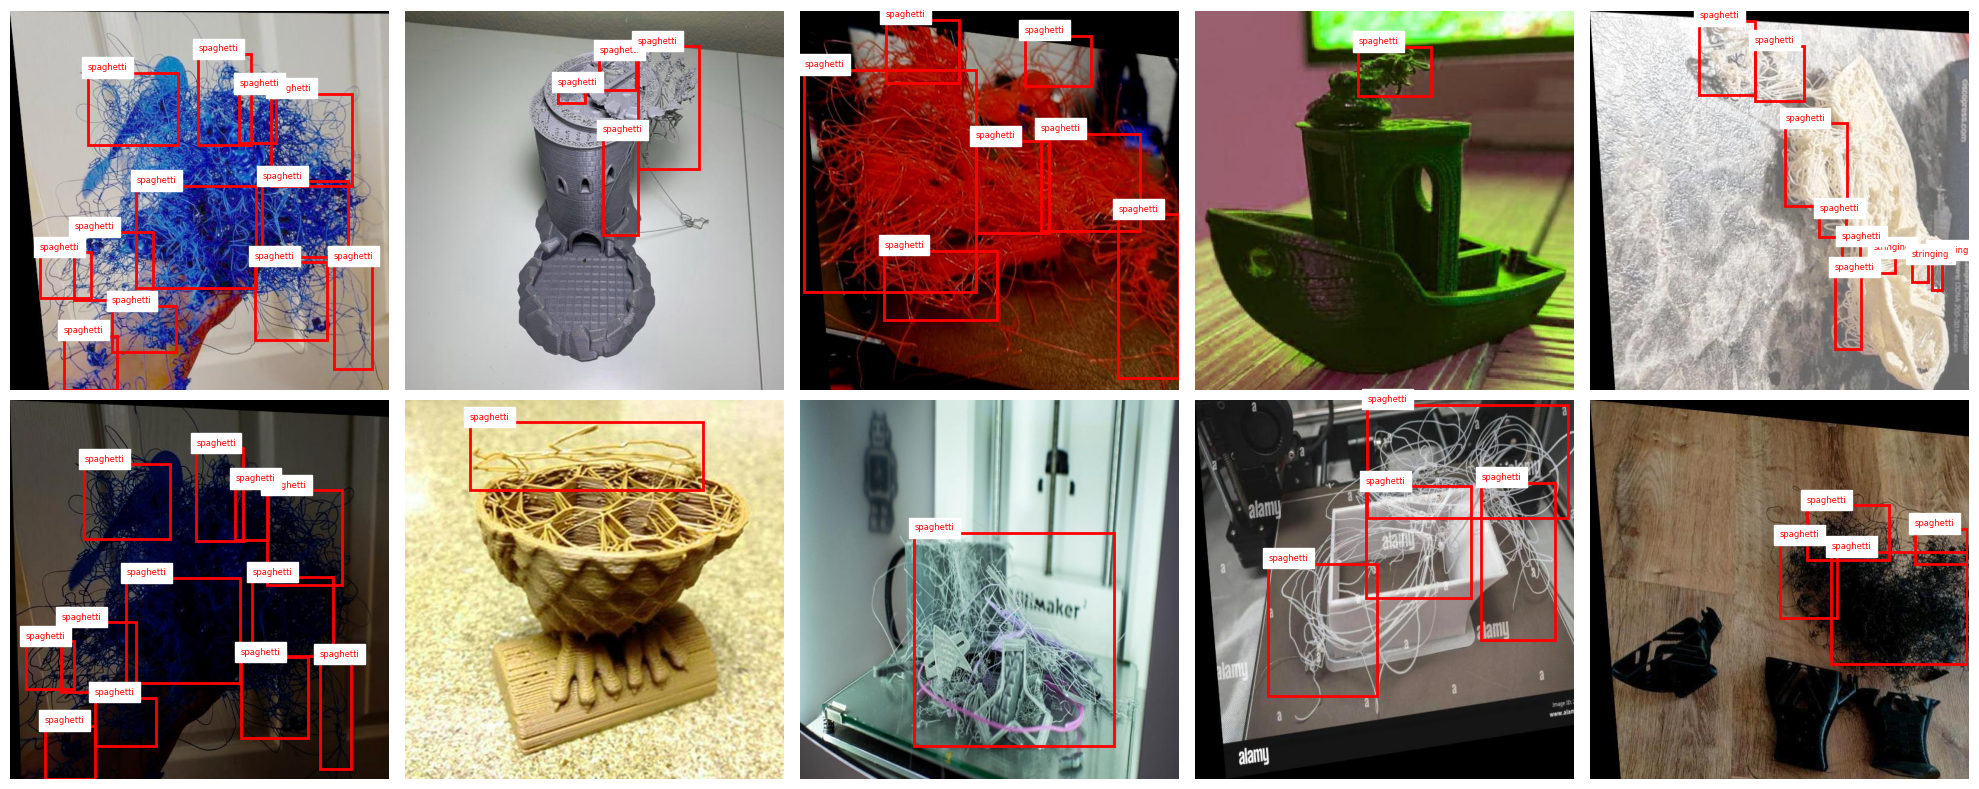

In [2]:
import json
import random
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# Paths
image_folder = 'images/unified_image_pool'
coco_path = 'images/unified_image_pool/all_annotations.coco.json'

# Load COCO data
with open(coco_path, 'r') as f:
    coco_data = json.load(f)

images = coco_data['images']
annotations = coco_data['annotations']
categories = {cat['id']: cat['name'] for cat in coco_data['categories']}

# Build image_id → annotations map
from collections import defaultdict
image_to_anns = defaultdict(list)
for ann in annotations:
    image_to_anns[ann['image_id']].append(ann)

# Pick 10 random images
sample_images = random.sample(images, 10)

# Set up 2x5 grid
fig, axes = plt.subplots(2, 5, figsize=(20, 8))

for ax, img_info in zip(axes.flatten(), sample_images):
    img_path = os.path.join(image_folder, img_info['file_name'])
    img = Image.open(img_path)

    ax.imshow(img)
    ax.axis('off')
    anns = image_to_anns[img_info['id']]

    for ann in anns:
        bbox = ann['bbox']  # [x, y, width, height]
        category_id = ann['category_id']
        label = categories[category_id]

        rect = patches.Rectangle(
            (bbox[0], bbox[1]),
            bbox[2],
            bbox[3],
            linewidth=2,
            edgecolor='red',
            facecolor='none'
        )
        ax.add_patch(rect)
        ax.text(
            bbox[0],
            max(bbox[1] - 5, 0),
            label,
            color='red',
            fontsize=6,
            backgroundcolor='white'
        )

plt.tight_layout()
plt.show()


In [3]:
import json
import os
import numpy as np
from PIL import Image, ImageDraw

output_mask_folder = 'images/unified_segmentation_masks'

# Create output directory
os.makedirs(output_mask_folder, exist_ok=True)

# Load COCO data
with open(coco_path, 'r') as f:
    coco_data = json.load(f)

# Build image_id → image_info map
image_id_to_info = {img['id']: img for img in coco_data['images']}

# Build image_id → annotations map
from collections import defaultdict
image_to_anns = defaultdict(list)
for ann in coco_data['annotations']:
    image_to_anns[ann['image_id']].append(ann)

# Process each image
for image_id, img_info in image_id_to_info.items():
    width = img_info['width']
    height = img_info['height']
    file_name = img_info['file_name']

    # Create blank mask (single-channel, black)
    mask = Image.new('L', (width, height), 0)  # 'L' = grayscale, 0 = black
    draw = ImageDraw.Draw(mask)

    # Draw bounding boxes as white rectangles
    for ann in image_to_anns[image_id]:
        bbox = ann['bbox']  # [x, y, width, height]
        x0 = bbox[0]
        y0 = bbox[1]
        x1 = x0 + bbox[2]
        y1 = y0 + bbox[3]
        draw.rectangle([x0, y0, x1, y1], fill=255)

    # Save mask as PNG
    mask_filename = os.path.splitext(file_name)[0] + '_mask.png'
    mask.save(os.path.join(output_mask_folder, mask_filename))

print(f"Generated masks saved to {output_mask_folder}/")


Generated masks saved to images/unified_segmentation_masks/


In [ ]:
import os
import random
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

resize_transform = transforms.Compose([
    transforms.Resize((512, 512)),
])


class SpaghettiDataset(Dataset):
    def __init__(self, image_dir, mask_dir, file_list, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_name = self.file_list[idx]
        img_path = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(self.mask_dir, os.path.splitext(img_name)[0] + '_mask.png')

        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')

        image = resize_transform(image)
        mask = resize_transform(mask)

        image = np.array(image) / 255.0
        mask = np.array(mask) / 255.0
        mask = (mask > 0.5).astype(np.float32)

        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)
        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)

        return image, mask

# Directories
image_dir = 'images/unified_image_pool'
mask_dir = 'images/unified_segmentation_masks'

# Collect image filenames
all_files = [f for f in os.listdir(image_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
random.shuffle(all_files)

# Split into train/val/test
n = len(all_files)
train_files = all_files[:int(0.8 * n)]
val_files = all_files[int(0.8 * n):int(0.9 * n)]
test_files = all_files[int(0.9 * n):]

# Create datasets
train_dataset = SpaghettiDataset(image_dir, mask_dir, train_files)
val_dataset = SpaghettiDataset(image_dir, mask_dir, val_files)
test_dataset = SpaghettiDataset(image_dir, mask_dir, test_files)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

print(f"Train: {len(train_dataset)} images")
print(f"Val: {len(val_dataset)} images")
print(f"Test: {len(test_dataset)} images")


Train: 572 images
Val: 71 images
Test: 72 images


In [2]:
import torch
import torch.nn as nn

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()

        self.down1 = DoubleConv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.down2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.down3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.down4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        self.bottleneck = DoubleConv(512, 1024)

        self.up4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.conv4 = DoubleConv(1024, 512)
        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv3 = DoubleConv(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv2 = DoubleConv(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv1 = DoubleConv(128, 64)

        self.out = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        d1 = self.down1(x)
        p1 = self.pool1(d1)
        d2 = self.down2(p1)
        p2 = self.pool2(d2)
        d3 = self.down3(p2)
        p3 = self.pool3(d3)
        d4 = self.down4(p3)
        p4 = self.pool4(d4)

        bn = self.bottleneck(p4)

        up4 = self.up4(bn)
        merge4 = torch.cat([up4, d4], dim=1)
        c4 = self.conv4(merge4)
        up3 = self.up3(c4)
        merge3 = torch.cat([up3, d3], dim=1)
        c3 = self.conv3(merge3)
        up2 = self.up2(c3)
        merge2 = torch.cat([up2, d2], dim=1)
        c2 = self.conv2(merge2)
        up1 = self.up1(c2)
        merge1 = torch.cat([up1, d1], dim=1)
        c1 = self.conv1(merge1)

        out = self.out(c1)
        return out


In [3]:
import torch.optim as optim

# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(in_channels=3, out_channels=1).to(device)

# Loss function
criterion = nn.BCEWithLogitsLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [4]:
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)

    avg_train_loss = train_loss / len(train_loader.dataset)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)

            loss = criterion(outputs, masks)
            val_loss += loss.item() * images.size(0)

    avg_val_loss = val_loss / len(val_loader.dataset)

    print(f"Epoch [{epoch + 1}/{num_epochs}] "
          f"Train Loss: {avg_train_loss:.4f} "
          f"Val Loss: {avg_val_loss:.4f}")


NotImplementedError: Subclasses of Dataset should implement __getitem__.

---

<a id='sec_evaluation'></a>

## **Evaluation**

*$\Rightarrow$ Describe the evaluation of your results.*

### **Instructions:**
* Select an evaluation method to compare two binary segmentation masks and quantify how well they match (e.g., using the Dice score).
* Hint: Implement a function `evaluate(mask1, mask2)` that returns the chosen evaluation score(s).
* Calculate the mean and standard deviation of the scores across the entire dataset.



---

<a id='sec_discussion'></a>

## **Discussion**

*$\Rightarrow$ Briefly discuss your results and share your key observations and your experiences and leaernings.*



---

<a id='sec_references'></a>

## **References**

*$\Rightarrow$ List all relevant references (as URLs).*

*Also, clearly state whether you used generative AI tools (e.g., ChatGPT, GitHub Copilot) and describe how they were used.*



<br><br><br><br><br><br><br><br>

---

<a id='sec_hints'></a>

## **Appendix: Hints**

### **Markdown / HTML**

The following tutorials might be useful if you are not yet familiar with Markdown:

- [Quick overview](https://www.writethedocs.org/guide/writing/markdown/)
- [Markdown GitHub-style](https://docs.github.com/en/get-started/writing-on-github/getting-started-with-writing-and-formatting-on-github/basic-writing-and-formatting-syntax)
- [More detailed tutorial](https://www.datacamp.com/tutorial/markdown-in-jupyter-notebook)

By the way: In Markdown cells, you can also use simple HTML (e.g., `<key>...</key>` blocks) to gain more control over formatting.





### **Display images**

You may want to display your data, if possible. Here are a few ways to do that:

An easy method for displaying 2D images is using the [**Pillow**](https://pillow.readthedocs.io/en/stable/) library:

In [ ]:
# Option 1: Display an image with Pillow
path = "../data/images/kidney-cells-lowres.jpg"
image = PIL.Image.open(path)
display(image)                  

If you are working with the data as a NumPy array (e.g., when using the OpenCV interface), you can also display it using **matplotlib**.

In [ ]:
# Option 2: OpenCV / Matplotlib
path = "../data/images/ct-brain-slices.jpg"
image = cv.imread(path)
plt.imshow(image)
plt.axis("off");

For convenience, we also provide a `display_image()` function in the **tools** library, which includes various utilities used throughout this course.

In [ ]:
# Option 3: Directly display a file
path = "../data/images/kidney-cells.jpg"
tools.display_image(path, scale=0.5)

<br>
<br>


### **Display overlays**

When segmenting images, you may want to overlay the input image with the segmentation mask.  
There are several ways to do this – here are a few ideas:


In [ ]:
################################################
# Idea 1: Overlay a color on a grayscale image
################################################

# Enforce a (3-channel) color image
path_image = "../data/images/neurons-cultured.jpg"
image = cv.imread(path_image, cv.IMREAD_COLOR)
image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

# Mask image
path_mask = "../data/images/neurons-cultured-mask.png"
mask = cv.imread(path_mask, cv.IMREAD_GRAYSCALE)

# Create overlay (RGB)
overlay_color = [255, 0, 0]
overlay_alpha = 0.3
overlay = image.copy()
overlay[mask > 0] = overlay_color
overlay = cv.addWeighted(image, 1 - overlay_alpha, overlay, overlay_alpha, 0)

# Display the images next to each other using a convenience function
tools.show_image_chain((image, overlay), titles=("Input", "Overlay"))

In [ ]:
################################################
# Idea 2: Overlay contours on a grayscale image
################################################

overlay_color = [255, 255, 0]
line_width = 1
contours, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
image_contours = image.copy()
cv.drawContours(image_contours, contours, -1, overlay_color, line_width)
tools.show_image_chain((image, image_contours), titles=("Input", "Contours"))

An advanced example: We can colorize different contours using distinct colors.

#### ***Strategy:***
- Use connected component labeling to assign a unique integer label to each region.
- Map each label to a different color by encoding it in the hue channel (in the HSV color space).
- Extract contours from the mask (ensure the mask is binary).
- Draw the contours with their assigned colors onto the original image.


In [ ]:
################################################
# Idea 3: Use colorized contours
################################################

# This will contain the result
image_contours = image.copy()

# Compute the "connected components" (= separate objects in the mask)
n_labels, labels = cv.connectedComponents(mask)

# Assign a different color to each label in the hue channel (HSV color space)
hue = np.uint8(150*labels/np.max(labels))
blank = 255*np.ones_like(hue)
labels = cv.merge([hue, blank, blank])

# Convert from HSV color space to RGB
labels = cv.cvtColor(labels, cv.COLOR_HSV2RGB)
# Set the background label (labels==0) to black
labels[labels==0] = 0

# Create a mask of the contours
line_width = 1
contours, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
mask_contours = cv.drawContours(np.zeros_like(mask), contours, -1, 255, line_width)

# Assign the colored labels only along the contours
image_contours[mask_contours>0] = labels[mask_contours>0]

# Display the result
tools.show_image_chain((image, image_contours), titles=("Input", "Labeled contours"))

<br>
<br>



### **How to convert a Jupyter notebook into a HTML/PDF:**

- Don't forget to **save your notebook** before converting!
- Install the conversion tool (if not already installed): `pip install nbconvert`
- Convert the notebook to an HTML file: `jupyter nbconvert --to html main.ipynb`  
  The HTML file will be saved in the same folder as your notebook.
- Open the HTML file in a browser and print (or save) it as a PDF.
- Tip: Using the Opera browser allows you to save the HTML as a single-page PDF, which often produces the best formatting (IMO).


In [ ]:
# Make sure you save this notebook, otherwise the HTML 
# output will not contain the latest version!!

# Make sure you have nbcovnert installed
!pip install nbconvert --quiet
# Save the notebook as HTML
!jupyter nbconvert --to html main.ipynb